# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load data

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
ecommerce_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/ecommerce_data.csv', header='infer')

if ecommerce_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {ecommerce_df.isna().sum().max()} NAs' )

print(ecommerce_df.info())
ecommerce_df.head(10)

There is no NA values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   is_mobile             500 non-null    int64  
 1   n_products_viewed     500 non-null    int64  
 2   visit_duration        500 non-null    float64
 3   is_returning_visitor  500 non-null    int64  
 4   time_of_day           500 non-null    int64  
 5   user_action           500 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 23.6 KB
None


,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2
5,1,1,0.512447,1,1,2
6,0,0,1.440327,1,1,0
7,1,0,0.035260,0,3,0
8,0,1,1.490764,0,0,1
9,0,0,0.005838,1,3,0


## pre-processing

In [4]:
def get_ecommerce_data(test_size=0.3):
  data = ecommerce_df.values

  X = data[:,:-1]
  Y = data[:,-1].astype(np.int32)

  N, D = X.shape
  X2 = np.zeros((N, D+3))
  X2[:, :(D-1)] = X[:, :(D-1)] # non-categorical
  X2[np.arange(N), D-1+X[:,D-1].astype(np.int32)] = 1 # one hot encode

  if test_size > 0.0:
    X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=test_size, random_state=42)
  else:
    X_train, X_test, Y_train, Y_test = X, None, Y, None
  
  # normalize columns 1 and 2
  for i in (1, 2):
    m = X_train[:,i].mean()
    s = X_train[:,i].std()
    X_train[:,i] = (X_train[:,i] - m) / s
    if X_test is not None:
      X_test[:,i] = (X_test[:,i] - m) / s

  return X_train, X_test, Y_train, Y_test

# Models

## Utils

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x, axis=1):
    x_exp = np.exp(x)
    return x_exp / x_exp.sum(axis=axis, keepdims=True)
  
def multiclass_cross_entropy(target, p_hat):
    # target = [[0, 1, 0], [0, 0, 1]]
    # p_hat = [[0.04, 0.95, 0.01], [0.1, 0.8, 0.1]]
    # returns [-0.05129329, -2.30258509]
    assert isinstance(p_hat, np.ndarray)
    assert isinstance(target, np.ndarray)
    assert target.shape == p_hat.shape
    assert len(target.shape) == 2 and target.shape[1] > 1
    log_p = np.log(p_hat[np.nonzero(target)])
    return -log_p.mean()

def r2(y, y_hat):
    assert isinstance(y, np.ndarray)
    assert isinstance(y_hat, np.ndarray)
    return 1 - sse(y, y_hat) / sse(y, np.array([y.mean()]))

def sse(y, y_hat):
    assert isinstance(y, np.ndarray)
    assert isinstance(y_hat, np.ndarray)
    assert len(y.shape) == 1 or y.shape[1] == 1
    err = (y - y_hat).flatten()
    result = err.dot(err)
    return result

def mse(y, y_hat):
    return sse(y, y_hat) / len(y)

def accuracy(target, y_hat):
    assert isinstance(y_hat, np.ndarray)
    assert isinstance(target, np.ndarray)
    assert target.shape == y_hat.shape
    assert len(target.shape) == 1 or len(target.shape) == 2
    if len(target.shape) == 1:
        return (y_hat == target).mean()
    if len(target.shape) == 2:
        target_ind = one_hot_2_vec(target)
        y_hat_ind = one_hot_2_vec(y_hat)
        return (target_ind == y_hat_ind).mean()
  
def ndarray_one_hot_encode(vec, width):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 1
    n = vec.shape[0]
    mat = np.zeros((n, width))
    mat[np.arange(n), vec] = 1
    return mat

def one_hot_2_vec(vec):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 2
    return np.argmax(vec, axis=1)

## MulticlassLogisticRegression model

In [12]:
class MulticlassLogisticRegression:
  def __init__(self, n_steps, n_classes=None, learning_rate=0.001, plot_training_history=False):
    self._activation = softmax
    self._n_steps = n_steps
    self._K = n_classes
    self._D = None
    self._learning_rate = learning_rate
    self._fit_history = None
    self._plot_training_history = plot_training_history

    self._target_label_size = None
    self.weights = None
    self.biases = None
    

  def fit(self, X, Y, initial_params = None):
    assert isinstance(X, np.ndarray) and len(X.shape) == 2
    assert isinstance(Y, np.ndarray)
    assert X.shape[0] == Y.shape[0]

    if len(Y.shape) == 1:
      print('Assume targets is 1d array with values corresponding to K classes')
      Y_Kd = ndarray_one_hot_encode(Y, self._K)
      self._target_label_size = 1
    else:
      print('Assume targets is one hot encoded Kd array with columns corresponding to K classes')
      assert np.all(Y.sum(axis=1) == np.ones(Y.shape[0]))
      Y_Kd = Y
      self._target_label_size = Y_Kd.shape[1]

    self._D = X.shape[1]
    if self._K is None:
      self._K = len(set(Y))
    
    w0, b0 = initial_params if initial_params is not None else self._initialize_weights()
    self.weights, self.biases,  self._fit_history = self._backward(X, Y_Kd, self._n_steps, w0, b0, self._learning_rate)
    

  def predict(self, X):
    assert isinstance(X, np.ndarray)
    p_hat = self._forward(X, self.weights, self.biases)
    y_hat_ind = np.argmax(p_hat, axis=1)
    if self._target_label_size == 1:
      return y_hat_ind
    else:
      return ndarray_one_hot_encode(y_hat_ind, self._target_label_size)
  
  def score(self, X, Y):
    assert isinstance(Y, np.ndarray)
    if self._target_label_size == 1:
      assert len(Y.shape) == 1
    else:
      assert len(Y.shape) == 2
      assert Y.shape[1] == self._target_label_size
    y_hat = self.predict(X)
    return accuracy(Y, y_hat)

  
  def _initialize_weights(self):
    w0 = np.random.randn(self._D, self._K) / np.sqrt(self._D)
    b0 = np.random.randn(self._K)
    return w0, b0
      

  def _backward(self, x, y, n_steps, w0, b0, learning_rate):
    hist = []

    p_hat = self._forward(x, w0, b0)
    loss_start = multiclass_cross_entropy(y, p_hat)
    acc_start = accuracy(np.argmax(y, axis=1), np.argmax(p_hat, axis=1))
    hist.append(np.array([loss_start, acc_start]))

    w = w0
    b = b0
    for step in range(1, n_steps+1):
      d_w = self._dw(x, y, p_hat)
      d_b = self._db(y, p_hat)
      w = w + learning_rate * d_w
      b = b + learning_rate * d_b

      p_hat = self._forward(x, w, b)
      loss = multiclass_cross_entropy(y, p_hat)
      acc = accuracy(np.argmax(y, axis=1), np.argmax(p_hat, axis=1))
      hist.append(np.array([loss, acc]))      

    hist = np.array(hist)
    if self._plot_training_history:
      plt.figure(figsize=(10,5))
      plt.plot(-1 *hist[:,0], label='loss')
      plt.legend()
      plt.show()

      plt.figure(figsize=(10,5))
      plt.plot(hist[:,1], label='accuracy')
      plt.legend()
      plt.show()
      print(f'final cost={hist[-1,0]}, final accuracy={hist[-1,1]}')

    return w, b, hist
  
  def _forward(self, x, w, b):
    assert isinstance(x, np.ndarray)
    return self._activation(x.dot(w) + b)

  def _dw(self, x, y, p_hat):
    return x.T.dot(y-p_hat)

  def _db(self, y, p_hat):
    return np.sum(y-p_hat, axis=0)

## ANN Sequential model

In [13]:
class Activation:
    @staticmethod
    def value(x):
        pass

    @staticmethod
    def derivative(x):
        pass

    @staticmethod
    def backprop_derivative(x):
        pass


class SigmoidActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return sigmoid(x)

    @staticmethod
    def derivative(x):
        simg_x = sigmoid(x)
        return simg_x * (1 - simg_x)

    @staticmethod
    def backprop_derivative(x):
        return x * (1 - x)


class TanhActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        ex = np.exp(x)
        e_x = np.exp(-x)
        return (ex - e_x) / (ex + e_x)

    @staticmethod
    def derivative(x):
        tanh_x = TanhActivation.value(x)
        return 1 - tanh_x * tanh_x

    @staticmethod
    def backprop_derivative(x):
        return 1 - x * x


class ReLUActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return x * ReLUActivation._step_fun(x)

    @staticmethod
    def derivative(x):
        return ReLUActivation._step_fun(x)

    @staticmethod
    def backprop_derivative(x):
        return ReLUActivation._step_fun(x)

    def _step_fun(x):
        result = np.zeros(x.shape)
        result[x > 0] = 1
        return result


class IdentityActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return x

    @staticmethod
    def derivative(x):
        return x

    @staticmethod
    def backprop_derivative(x):
        return x


class SoftmaxActivation(Activation):
    def __init__(self):
        super().__init__()

    @staticmethod
    def value(x):
        return softmax(x, axis=1)

    @staticmethod
    def derivative(x):
        softmax_x = softmax(x, axis=1)
        return softmax_x * (1 - softmax_x)

    @staticmethod
    def backprop_derivative(x):
        raise NotImplemented()


In [14]:
class Layer:
    def __init__(self, imput_dim, output_dim):
        assert imput_dim is not None
        assert output_dim is not None
        self._input_dim = imput_dim
        self._output_dim = output_dim

    def forward(self, z):
        pass

    def initialize_params(self):
        pass

    def update_params(self, learning_rate, delta, z):
        pass

    def propagate_delta_back(self, delta):
        pass

    def calc_gradient_delta(self, delta, z):
        pass


class DenseLayer(Layer):
    def __init__(self, imput_dim, output_dim, activation, init_params=None):
        super().__init__(imput_dim, output_dim)
        if activation is not None:
            assert isinstance(activation, Activation)
        self.activation = activation
        if init_params is not None:
            assert len(init_params) == 2
            self.weights, self.biases = init_params
        else:
            self.initialize_params()

    def forward(self, x):
        assert x.shape[1] == self._input_dim
        a = x.dot(self.weights) + self.biases
        if self.activation is None:
            out = a
        else:
            out = self.activation.value(a)
        if self._output_dim == 1:
            assert out.shape[0] == x.shape[0]
            out = out.reshape(-1, self._output_dim)
        else:
            assert out.shape == (x.shape[0], self._output_dim)
        return out

    @staticmethod
    def _dw(z, err):
        return z.T.dot(err)

    @staticmethod
    def _db(err):
        return np.sum(err, axis=0)

    def initialize_params(self):
        self.weights = np.random.randn(self._input_dim, self._output_dim) / np.sqrt(self._output_dim)
        self.biases = np.random.randn(self._output_dim)

    def update_params(self, learning_rate, delta, z):
        d_w = z.T.dot(delta)
        d_b = np.sum(delta, axis=0)
        self.weights = self.weights + learning_rate * d_w
        self.biases = self.biases + learning_rate * d_b

    def propagate_delta_back(self, delta):
        if len(delta.shape) == 1 and len(self.weights.shape) == 1:
            result = np.outer(delta, self.weights)
        else:
            assert len(delta.shape) == 2 and len(self.weights.shape) == 2
            assert delta.shape[1] == self.weights.T.shape[0]
            result = delta.dot(self.weights.T)
        return result

    def calc_gradient_delta(self, delta, z):
        result = delta * self.activation.backprop_derivative(z)
        return result


In [15]:
class NNSequential:
    def __init__(self, layers, n_steps, learning_rate=0.001, plot_training_history=False):
        self.layers = layers
        self._n_steps = n_steps
        self._learning_rate = learning_rate
        self._fit_history = None
        self._plot_training_history = plot_training_history
        self.fit_history = None

    def fit(self, X, Y):
        pass

    def predict(self, X):
        pass

    def score(self, X, Y):
        pass

    def _fit_prepare(self, X, Y):
        assert isinstance(X, np.ndarray) and len(X.shape) == 2
        assert isinstance(Y, np.ndarray)
        assert X.shape[0] == Y.shape[0]
        self.fit_history = []

    def _backward(self, x, y):
        # print(f'-------------step 0-------------')
        feature_values_by_layer = self._forward(x)
        self._calc_fit_scores(y, feature_values_by_layer[-1])

        for step in range(1, self._n_steps + 1):
            # print(f'-------------step {step}-------------')
            self._update_params(y, feature_values_by_layer)

            feature_values_by_layer = self._forward(x)
            self._calc_fit_scores(y, feature_values_by_layer[-1])

        hist = np.array(self.fit_history)
        if self._plot_training_history:
            self._plot_history(hist)

        return hist

    def _plot_history(self, history):
        pass

    def _calc_fit_scores(self, forward_result, p_hat):
        pass

    def _update_params(self, y, z_by_layers):
        n_layers = len(self.layers)

        deltas = []
        deltas.append(y - z_by_layers[-1])
        for l_idx in reversed(range(n_layers - 1)):
            current_layer = self.layers[l_idx]
            current_layer_z = z_by_layers[l_idx + 1]
            following_layer = self.layers[l_idx + 1]
            following_layer_delta = deltas[-1]

            back_propagated_delta = following_layer.propagate_delta_back(following_layer_delta)
            deltas.append(current_layer.calc_gradient_delta(back_propagated_delta,  current_layer_z))
        deltas.reverse()

        for l_idx in range(n_layers):
            layer = self.layers[l_idx]
            layer.update_params(self._learning_rate, deltas[l_idx], z_by_layers[l_idx])

    def _forward(self, x):
        out_feature_values_by_layer = [x]
        z = x
        for layer in self.layers:
            z = layer.forward(z)
            out_feature_values_by_layer.append(z)
        return out_feature_values_by_layer


class NNSequentialClassifier(NNSequential):
    def __init__(self, layers, n_steps, n_classes=None, learning_rate=0.001,
                 plot_training_history=False):
        super().__init__(layers, n_steps, learning_rate, plot_training_history)
        self._K = n_classes
        self._target_label_size = None

    def fit(self, X, Y):
        super()._fit_prepare(X, Y)

        if len(Y.shape) == 1:
            print('Assume targets is 1d array with values corresponding to K classes')
            Y_Kd = ndarray_one_hot_encode(Y, self._K)
            self._target_label_size = 1
        else:
            print('Assume targets is one hot encoded Kd array with columns corresponding to K classes')
            assert np.all(Y.sum(axis=1) == np.ones(Y.shape[0]))
            Y_Kd = Y
            self._target_label_size = Y_Kd.shape[1]

        if self._K is None:
            self._K = len(set(Y))

        return self._backward(X, Y_Kd)

    def predict(self, X):
        assert isinstance(X, np.ndarray)
        y_hat_ind = self._predict_ind(X)
        if self._target_label_size == 1:
            return y_hat_ind
        else:
            return ndarray_one_hot_encode(y_hat_ind, self._target_label_size)

    def _predict_ind(self, X):
        layers_output = self._forward(X)
        p_hat = layers_output[-1]
        return np.argmax(p_hat, axis=1)

    def score(self, X, Y):
        assert isinstance(X, np.ndarray)
        assert isinstance(Y, np.ndarray)
        assert X.shape[0] == Y.shape[0]
        if self._target_label_size == 1:
            assert len(Y.shape) == 1
            T_ind = Y
        else:
            assert len(Y.shape) == 2 and Y.shape[1] > 1
            T_ind = one_hot_2_vec(Y)
        y_hat_ind = self._predict_ind(X)
        return self._accuracy_ind(T_ind, y_hat_ind)

    @staticmethod
    def _accuracy_ind(target, y_hat_ind):
        return (target == y_hat_ind).mean()

    def _calc_fit_scores(self, y, p_hat):
        loss = multiclass_cross_entropy(y, p_hat)
        acc = self._accuracy_ind(np.argmax(y, axis=1), np.argmax(p_hat, axis=1))
        self.fit_history.append(np.array([loss, acc]))

    def _plot_history(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(-1 * history[:, 0], label='loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(history[:, 1], label='accuracy')
        plt.legend()
        plt.show()
        print(f'final cost={history[-1, 0]}, final accuracy={history[-1, 1]}')


class NNSequentialRegressor(NNSequential):
    def __init__(self, layers, n_steps, learning_rate=0.001, plot_training_history=False):
        super().__init__(layers, n_steps, learning_rate, plot_training_history)

    def fit(self, X, Y):
        super()._fit_prepare(X, Y)
        assert len(Y.shape) == 1 or (len(Y.shape) == 2 and Y.shape[1] == 1)
        self._initial_target_shape = Y.shape
        return self._backward(X, Y.reshape(-1, 1))

    def predict(self, X):
        assert isinstance(X, np.ndarray)
        layers_out = self._forward(X)
        y_hat = layers_out[-1]
        assert len(y_hat.shape) == 2 and y_hat.shape[1] == 1
        if len(self._initial_target_shape) == 1:
            return y_hat.flatten()
        else:
            return y_hat.reshape(-1, 1)

    def score(self, X, Y):
        assert isinstance(X, np.ndarray)
        assert isinstance(Y, np.ndarray)
        assert X.shape[0] == Y.shape[0]
        y_hat = self.predict(X)
        return mse(Y, y_hat)

    def _calc_fit_scores(self, y, y_hat):
        y_hat = y_hat.reshape(y.shape)
        loss = mse(y, y_hat)
        R2 = r2(y, y_hat)
        self.fit_history.append(np.array([loss, R2]))

    def _plot_history(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(-1 * history[:, 0], label='mse')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(history[:, 1], label='R2')
        plt.legend()
        plt.show()
        print(f'final cost MSE={history[-1, 0]}, final R2={history[-1, 1]}')


# Predictions

In [16]:
Xtrain, Xtest, Ytrain, Ytest = get_ecommerce_data(test_size=0.2)

D = Xtrain.shape[1]
K = len(set(Ytrain) | set(Ytest))

Ytrain_ind = ndarray_one_hot_encode(Ytrain, K)
Ytest_ind = ndarray_one_hot_encode(Ytest, K)

W0 = np.random.randn(D, K)
b0 = np.zeros(K)

## use MulticlassLogisticRegression

Assume targets is 1d array with values corresponding to K classes


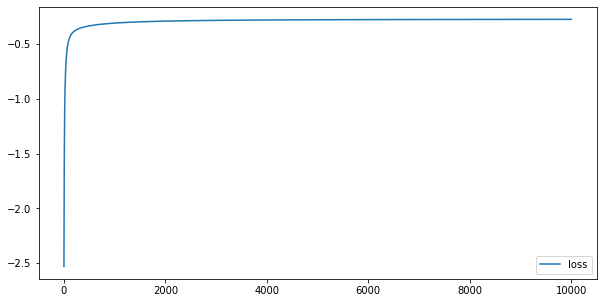

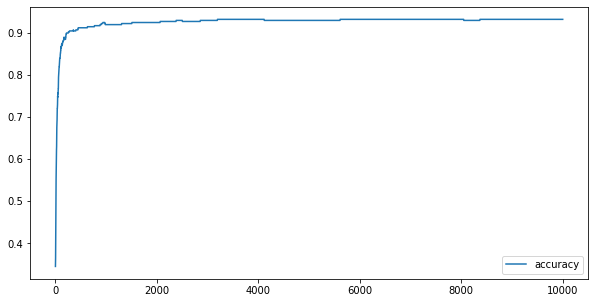

final cost=0.27614336380373866, final accuracy=0.9325
Final weights: [[-3.33488523 -2.01902235  1.30844493  4.25325772]
 [-7.2388671   1.0616498   2.56884758  4.76533624]
 [-0.8636332  -1.93387318  1.02288127  3.49455301]
 [-1.66710508 -0.27846139  1.13959384  4.43054034]
 [-0.67778699 -0.55407024  0.3619495   0.87519419]
 [ 0.38731914 -1.34317976  0.35887153 -1.661093  ]
 [ 2.6039904   1.09523414 -0.62812351 -3.81296937]
 [ 3.72873899  2.51546973  0.57749029 -6.2344182 ]]
Final biases: [ 3.71671819  4.19004302  0.09760761 -8.00436882]
Train accuracy: 0.9325
Test accuracy: 0.86


In [17]:
lr_model = MulticlassLogisticRegression(n_steps=10000, n_classes=K, learning_rate=0.001, plot_training_history=True)
lr_model.fit(Xtrain, Ytrain, (W0, b0))

assert lr_model.score(Xtrain, lr_model.predict(Xtrain)) == 1

print("Final weights:", lr_model.weights)
print("Final biases:", lr_model.biases)

print('Train accuracy:', lr_model.score(Xtrain, Ytrain))
print('Test accuracy:', lr_model.score(Xtest, Ytest))

## use 2 layer NN

Assume targets is one hot encoded Kd array with columns corresponding to K classes


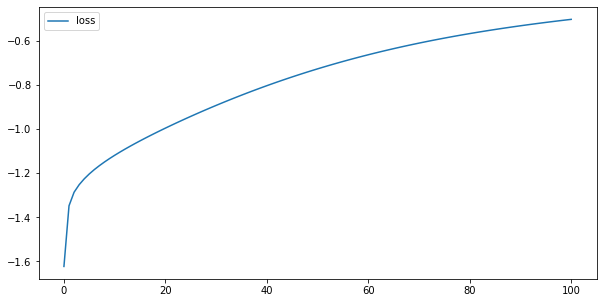

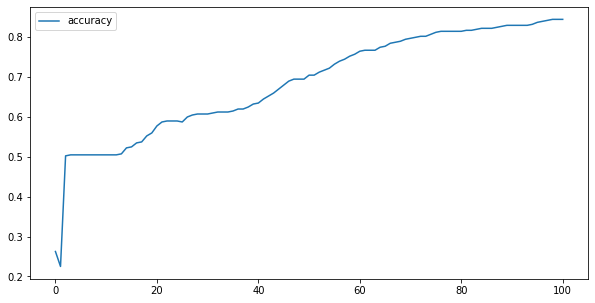

final cost=0.5022565349513232, final accuracy=0.845
Final weights layer 0: [[ 4.42974823e-01 -5.97483940e-03 -3.01522997e-01  2.68050918e-01
  -3.79454387e-01 -4.41866055e-01 -1.66384835e-01 -1.86338883e-01
   3.66968535e-01 -3.32925995e-01  1.59999447e-01 -8.00336737e-02
   4.18240963e-01  3.73873219e-01  2.13932996e-01  6.99782322e-01]
 [-8.94565581e-01  1.02147363e-03 -4.16425187e-03  1.09344684e+00
   2.05770738e-01 -5.62501298e-01  1.40751167e+00 -1.13283593e-01
  -1.92577414e-02 -1.85194787e+00 -1.37396241e+00 -1.56009249e-01
  -4.39425813e-01 -4.20564604e-01  1.47362120e+00  7.05348567e-01]
 [-1.06728334e-01 -1.74588694e-01 -4.91572866e-01  2.25271285e-01
  -6.52353512e-01 -2.40573697e-01 -8.01130069e-02 -8.85470323e-01
  -8.34732873e-01  4.39412232e-02  1.09361845e-01 -4.52074982e-01
   1.72127086e-01 -3.52014310e-01  2.94969585e-02  7.89210942e-01]
 [-3.02316277e-01 -4.31255887e-02  1.22615572e-01 -2.59548144e-01
  -6.22850328e-02 -3.14348016e-02  2.12727836e-01  1.86883251e-0

In [20]:
D = Xtrain.shape[1]
M = 16
K = Ytrain_ind.shape[1]

l0 = DenseLayer(D, M, SigmoidActivation())#, init_params=[W1, b1])
lN = DenseLayer(M, K, SoftmaxActivation())#, init_params=[W3_2, b3_2])
nn2l_model = NNSequentialClassifier(layers=[l0, lN], n_steps=100, n_classes=K, plot_training_history=True)

nn2l_model.fit(Xtrain, Ytrain_ind)
assert nn2l_model.score(Xtrain, nn2l_model.predict(Xtrain)) == 1

print("Final weights layer 0:", nn2l_model.layers[0].weights)
print("Final biases layer 0:", nn2l_model.layers[0].weights)
print("Final weights layer 1:", nn2l_model.layers[1].weights)
print("Final biases layer 1:", nn2l_model.layers[1].weights)

print('Train accuracy:', nn2l_model.score(Xtrain, Ytrain_ind))
print('Test accuracy:', nn2l_model.score(Xtest, Ytest_ind))

Assume targets is 1d array with values corresponding to K classes


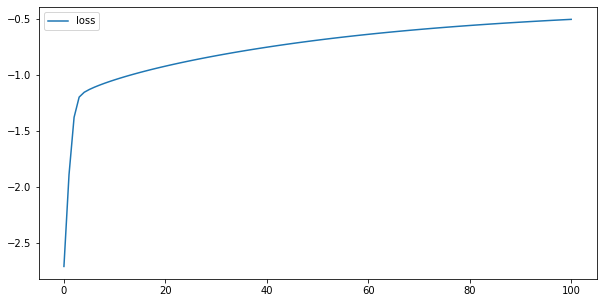

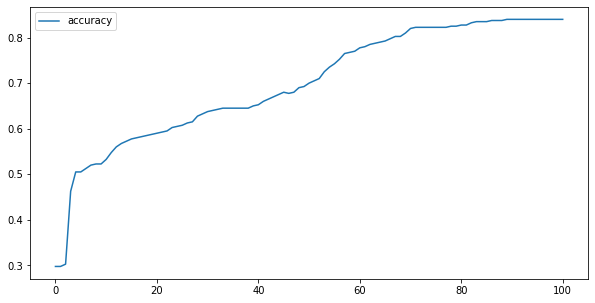

final cost=0.5066916019453928, final accuracy=0.84
Final weights layer 0: [[-3.13961669e-01  4.06117561e-01  2.80176514e-01  7.33679830e-02
   3.21158236e-02  2.20179534e-01 -6.11384490e-01  7.24846539e-02
  -3.47014498e-01 -4.44512928e-01 -2.53491026e-01 -2.73314146e-01
   3.33711386e-01 -1.15461748e-01 -2.76131204e-01  7.67165526e-02]
 [ 2.57737919e-01  1.03057899e+00  1.22241062e+00  2.09246217e-01
  -1.30376519e+00 -1.02661047e+00 -8.28697503e-01  1.95323174e-01
  -4.02046761e-01 -7.81953908e-01  5.32696393e-01  2.80908383e-01
   1.21572632e+00 -1.71519144e+00 -7.89741006e-01 -1.57258176e-01]
 [-5.51719040e-01  6.62211788e-01  2.66760563e-01  1.84458705e-01
  -3.22522183e-01  2.12036578e-01 -9.93898860e-01  5.00629197e-01
  -7.24042797e-04 -1.09224765e-01 -9.42416410e-01  8.47909818e-02
  -2.36007455e-01  4.39836963e-01  2.11796863e-01  1.83910047e-01]
 [-1.96229422e-02  1.80508286e-01  1.98275329e-01  1.00307162e-01
  -1.07225581e-01 -1.74551939e-01 -5.03421099e-01  3.09250955e-01

In [24]:
D = Xtrain.shape[1]
M = 16
K = Ytrain_ind.shape[1]

l0 = DenseLayer(D, M, SigmoidActivation())#, init_params=[W1, b1])
lN = DenseLayer(M, K, SoftmaxActivation())#, init_params=[W3_2, b3_2])
nn2l_model = NNSequentialClassifier(layers=[l0, lN], n_steps=100, n_classes=K, plot_training_history=True)

nn2l_model.fit(Xtrain, Ytrain)
assert np.all(nn2l_model.score(Xtrain, nn2l_model.predict(Xtrain))) == 1

print("Final weights layer 0:", nn2l_model.layers[0].weights)
print("Final biases layer 0:", nn2l_model.layers[0].biases)
print("Final weights layer 1:", nn2l_model.layers[1].weights)
print("Final biases layer 1:", nn2l_model.layers[1].biases)

print('Train accuracy:', nn2l_model.score(Xtrain, Ytrain))
print('Test accuracy:', nn2l_model.score(Xtest, Ytest))

Assume targets is 1d array with values corresponding to K classes


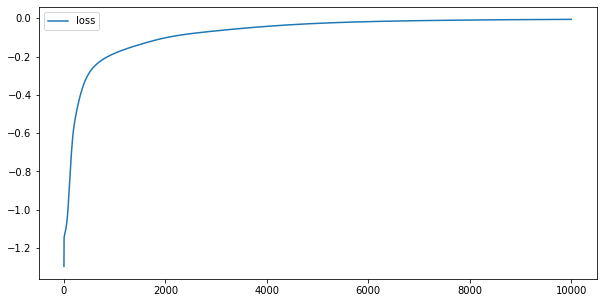

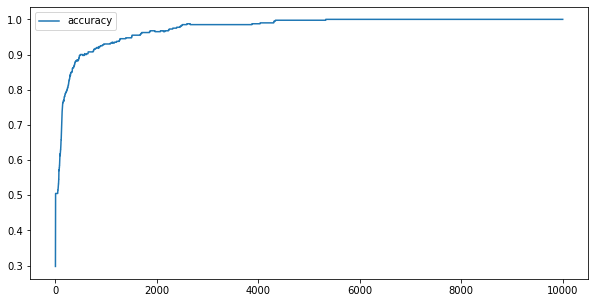

final cost=0.005712203058166958, final accuracy=1.0
Final weights layer 0: [[-2.49219784 -3.07236218  1.08480016  0.87458681 -0.25694201  0.61805462
   0.66135007  0.23727714  0.8997154  -0.22884348 -0.39239919  1.78075699
  -0.50161813 -0.04910852  1.26826402 -2.48177326]
 [ 0.57599609  0.16713657  0.21129103  1.26270005  2.88284956  0.22821825
  -2.75596511  0.93383005 -2.31649689 -4.9137006  -1.25854144  2.114907
  -0.79936799 -1.88821578 -3.44381981  2.70556075]
 [-2.63979529 -0.20651977  3.08104355  2.01600378 -0.78447195  0.94421131
  -0.14052506  0.77713261  2.03740886  0.84973636  0.60604029  3.60395378
  -1.1833617  -0.73885747  1.41985024 -2.77223977]
 [-3.01879485 -1.83154142  1.54045924  0.48504832 -0.04608583  1.7778982
   0.51534963  0.2969776   1.89569379 -0.14336883 -0.84302021 -0.07000722
  -1.92013713  0.12323845  1.02788794 -1.59095737]
 [-1.6715322   0.66999205  0.60552005  0.88201914  0.20328343  0.53895252
  -0.55017918  0.39701001  0.88295855 -0.76319898 -0.63359

In [26]:
D = Xtrain.shape[1]
M1 = 16
M2 = 24
K = Ytrain_ind.shape[1]

l0 = DenseLayer(D, M1, SigmoidActivation())#, init_params=[W1, b1])
l1 = DenseLayer(M1, M2, SigmoidActivation())#, init_params=[W2_2, b2_2])
lN = DenseLayer(M2, K, SoftmaxActivation())#, init_params=[W3_2, b3_2])
nn3l_model = NNSequentialClassifier(layers=[l0, l1, lN], n_steps=10000, n_classes=K, plot_training_history=True)

nn3l_model.fit(Xtrain, Ytrain)

assert np.all(nn3l_model.score(Xtrain, nn3l_model.predict(Xtrain))) == 1

print("Final weights layer 0:", nn3l_model.layers[0].weights)
print("Final biases layer 0:", nn3l_model.layers[0].biases)
print("Final weights layer 1:", nn3l_model.layers[1].weights)
print("Final biases layer 1:", nn3l_model.layers[1].biases)
print("Final weights layer 2:", nn3l_model.layers[2].weights)
print("Final biases layer 2:", nn3l_model.layers[2].biases)

print('Train accuracy:', nn3l_model.score(Xtrain, Ytrain))
print('Test accuracy:', nn3l_model.score(Xtest, Ytest))